# Classifying customer complaints using Watson NLP

This notebook demonstrates how to train text classifiers using Watson NLP. The classifiers predict the product group from the text of a customer complaint. This could be used, for example to route a complaint to the appropriate staff member. 

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), a U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains the consumer’s narrative description of their experience if the consumer opted to share this information publicly and after the Bureau has removed all personal information. In this notebook, you will focus on complaints that contain this narrative description to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/.


## What you'll learn in this notebook

Watson NLP implements state-of-the-art classification algorithms from three different families: 
- Classic machine learning using SVM (Support Vector Machines): SVM is a support vector machine classifier, which may be trained using any type of input embedding / vectorization block’s predictions as feature vectors, e.g., USE embeddings, TF-IDF vectorizers. Supports multi-class and multi-label text classification and produces confidence scores via Platt Scaling.
- Deep learning using CNN (Convolutional Neural Networks): CNN is a simple convolutional network architecture, built for multi-class and multi-label text classification on short texts. Utilizes GloVe embeddings.
- BERT: BERT is a transformer-based architecture, built for multi-class and multi-label text classification on short texts. Utilizes Multilingual BERT pretrained models.
- A transformer-based architecture: Transformer is a transformer-based architecture, built for multi-class and multi-label text classification on short texts. Utilizes BERT and RoBERTa pretrained models.

Watson NLP also offers an easy to use _ensemble classifier_ which combines different classification algorithms and a majority voting.

In this notebook, you'll learn how to:

- **Prepare your data** so that it can be used as training data for the Watson NLP classification algorithms.
- **Train a TF-IDF SVM model** using `watson_nlp.workflows.classification.TFidfSvm`. TFidfSvm workflow simplifies the training process of `TF-IDF vectorization+SVM`
- **Train a USE SVM model** using `watson_nlp.workflows.classification.UseSvm`. UseSvm workflow simplifies the training process of `USE embedding+SVM`
- **Train a Glove CNN model** using `watson_nlp.workflows.classification.GloveCNN`. GloveCNN workflow simplifies the training process of `Glove embedding + CNN`
- **Train a VotingEnsemble** using `watson_nlp.workflows.classification.GenericEnsemble`. The GenericEnsemble model combines three classification models: CNN with Glove Embedding, SVM with TF-IDF and SVM with USE (Universal Sentence Encoder). It computes the weighted mean of classification predictions using confidence scores.
- **Store and load classification models** as an asset of a Watson Studio project.
- **Score data and compare model quality** by running the models on test data and using the built-in quality evaluation and building a custom confusion matrix.


## Table of Contents


1.	[Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.	[Data Processing](#prepareData)
    1. [Prepare training and test data](#prepareTraining)
1.  [Model Building](#buildModel)
    1. [Train a TF-IDF SVM classification model with Watson NLP](#tfidfsvm)
    1. [Train a USE SVM classification model with Watson NLP](#usesvm)
    1. [Train a Golve CNN classification model with Watson NLP](#cnn)
    1. [Train an ensemble classification model with Watson NLP](#ensemble)
    1. [Store and load classification models](#storeLoad)
1.  [Model Evaluation](#evaluate)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
## Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _DO + NLP Runtime XX.x on Python 3.x_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>

In [2]:
%%capture
# word cloud is used to create graphs below
!pip install wordcloud
!pip install ibm-watson

In [3]:
import watson_nlp
# Silence Tensorflow warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [4]:
import json
import pandas as pd
from time import process_time
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import watson_nlp
from datetime import datetime

In [5]:
from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.toolkit import fileio
from watson_nlp.workflows.classification.base_classifier.tfidf_svm import TFidfSvm
from watson_nlp.workflows.classification.base_classifier.use_svm import UseSvm
from watson_nlp.workflows.classification.generic_ensemble import GenericEnsemble
from watson_nlp.workflows.classification.base_classifier import GloveCNN
from watson_core.toolkit.quality_evaluation import QualityEvaluator, EvalTypes

<a id="loadData"></a>
## Data Loading (customer complaint data)

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. The data is exported in CSV format.

Read the data into a dataframe.
You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In your analysis you will focus on the *Product* column, which contains the product group, and the column with the complaint text *Consumer complaint narrative*.

<span style="color:blueviolet">We load the consumer complaints into a DataFrame.</span>

<span style="color:blue">This data set contains 999285 consumer complaints with the date received,product,sub-product, submitted via and company information.</span>

In [6]:
# load data set into a dataframe
buffer = project.get_file("complaint_data.csv")
complaint_df = pd.read_csv(buffer)
text_col = 'Consumer complaint narrative'

# preview the data set
complaint_df.head()

Unnamed: 0.1  Unnamed: 0 Date received  \
0        245996      796632    2015-09-25   
1        572838     1774085    2018-02-25   
2        755475     2201866    2018-08-04   
3        183523      472861    2019-09-30   
4        228506      697804    2018-04-25   

                                                                        Product  \
0                                                       Bank account or service   
1                                                               Debt collection   
2  Credit reporting, credit repair services, or other personal consumer reports   
3                            Money transfer, virtual currency, or money service   
4                            Money transfer, virtual currency, or money service   

                 Sub-product                                 Issue  \
0           Checking account             Using a debit or ATM card   
1                 Other debt     Attempts to collect debt not owed   
2           Credit reporting  Incorrect information on your report   
3  Foreign currency exchange                         Fraud or scam   
4   Mobile or digital wallet                         Fraud or scam   

                             Sub-issue  \
0                                  NaN   
1                    Debt is not yours   
2  Information belongs to someone else   
3                                  NaN   
4                                  NaN   

                                                                                                                                                                                                                                                                                                                                                                                      Consumer complaint narrative  \
0  My husband and I notified our Bank on XXXX XXXX, and XXXX that we had several unauthorized transactions resulting from a XXXX XXXX that we used rewards points to stay at. As a result of our stay with XXXX, we were supposed to be given diamond membership status and we were supposed to be given the best rate guarantee but neither were provided so we were double charged and overbilled. We contact...   
1  See complaint ID : XXXX Continued attempts to collect a debt not owed. All previous debt collections agencies that XXXX XXXX has sent this debt to have discontinued contact. \n\nXXXX continues to have these debt collectors harass me.\n\nCFPB, Credit reporting agencies have all decided in my favor. \n\nI want XXXX to tell me they are no longer going to purse this bogus " debt '' or I will pursu...   
2                                                                                                                                                                                                                                        XXXX, XXXX AND TRANSUNION HAVE inaccurate information on credit report please let them know that my cra and ftc rights have been violated code protection consumer rights   
3  I found XXXX, XXXX pesos bills while cleaning out my garage. I didn't know where to exchange them or their worth and asked several people. I was told to try BBVA. I went to one branch and was told they would exchange the pesos at 19 %, approximately  {$1500.00} US dollars, but only if I had a checking or savings account. I was told by a teller that I had to have a {$25.00} deposit to open an a...   
4  On XX/XX/2018, I purchased a " XXXX '' item from XXXX The item arrived after the date promised and the shipping cost more than the item itself, supposedly due to the " rush shipping '' ; the cost of shipping was actually due to the item being shipped from overseas ( misleading from the store 's claim to be located in " CA XXXX, United States of America '', as shown here : XXXX ) The item was e...   

                                                                           Company public response  \
0                   

<a id="prepareData"></a>
## 3. Data Processing & EDA

Let's look at all product groups that are available in the data set because these are the classes that the classifier should predict from a given complaint text.

In [7]:
complaint_df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    8683
Debt collection                                                                 3645
Mortgage                                                                        1840
Credit card or prepaid card                                                     1462
Checking or savings account                                                      954
Credit reporting                                                                 653
Student loan                                                                     626
Money transfer, virtual currency, or money service                               483
Vehicle loan or lease                                                            405
Credit card                                                                      400
Bank account or service                                                          303
Payday loan, title loan, or personal loan                        

<a id="prepareTraining"></a>
## 3.A Prepare training and test data

Many classification algorithms work best if the training samples are equally split across the classes. If the data is unbalanced, algorithms might decide to favor classes with many samples to achieve an overall good result. To avoid this, you will sample the data in the next step to have a similar amount of samples for each class.

To avoid long runtimes in this sample notebook, you will use only a small number of samples. However, this can reduce the quality of the classification models. In a real-case scenario, you should increase the number of samples per product group to get better results.

In [8]:
# Filtering on the Product categories with relevant number of samples. 
# The remaining categories will not be used in further analysis and classification models
train_test_df = complaint_df[(complaint_df['Product'] == 'Credit reporting, credit repair services, or other personal consumer reports') | \
                             (complaint_df['Product'] == 'Debt collection') | \
                             (complaint_df['Product'] == 'Mortgage') | \
                             (complaint_df['Product'] == 'Credit card or prepaid card') | \
                             (complaint_df['Product'] == 'Checking or savings account')
                            ]

<span style="color:blueviolet">In the next step, you will split the data into training and test data (ratio:80/20).</span>

In [9]:
# 80% training data
train_orig_df = train_test_df.groupby('Product').sample(frac=0.8, random_state=6)
print("Training data:")
print("Number of training samples: {}".format(len(train_orig_df)))
print("Samples by product group:\n{}".format(train_orig_df['Product'].value_counts()))

# 20% test data
test_orig_df = train_test_df.drop(train_orig_df.index)
print("\nTest data:")
print("Number of test samples: {}".format(len(test_orig_df)))
print("Samples by product group:\n{}".format(test_orig_df['Product'].value_counts()))

# re-index after sampling
train_orig_df = train_orig_df.reset_index(drop=True)
test_orig_df = test_orig_df.reset_index(drop=True)

Training data:
Number of training samples: 13267
Samples by product group:
Credit reporting, credit repair services, or other personal consumer reports    6946
Debt collection                                                                 2916
Mortgage                                                                        1472
Credit card or prepaid card                                                     1170
Checking or savings account                                                      763
Name: Product, dtype: int64

Test data:
Number of test samples: 3317
Samples by product group:
Credit reporting, credit repair services, or other personal consumer reports    1737
Debt collection                                                                  729
Mortgage                                                                         368
Credit card or prepaid card                                                      292
Checking or savings account                                      

You have created two dataframes, one for the training and one for the test data. The data is still in its original format. Now you need to bring the data into a format that is usable by the Watson NLP classification algorithms. This can be either *JSON* or *CSV* format. 

<span style="color:blueviolet">In the sample, you will create the data in *JSON* format. The training and test data is written to files.</span>

In [10]:
def prepare_data(df):
    # only the text column and the target label *Product* are needed
    df_out = df[['Consumer complaint narrative', 'Product']].reset_index(drop=True)
    # rename to the identifiers expected by Watson NLP
    df_out = df_out.rename(columns={"Consumer complaint narrative": "text", 'Product': 'labels'})
    # the label column should be an array (although we have only one label per complaint)
    df_out['labels'] = df_out['labels'].map(lambda label: [label,])
    return df_out
    
train_df = prepare_data(train_orig_df)
train_file = './train_data.json'
train_df.to_json(train_file, orient='records')
    
test_df = prepare_data(test_orig_df)
test_file = './test_data.json'
test_df.to_json(test_file, orient='records')

train_df.head(2)

text  \
0  I have received several correspondences from Well Fargo including a Checking Account Statement. I did not apply for, or authorize Wells Fargo to open an account in my name. All information on the account, specifically my Social Security Number, Drivers License Number and Birth Date were correct. The only incorrect information was the expiry date on my driver 's license. This leads me to suspec...   
1  In the Spring of XX/XX/XXXX, Wells Fargo notified me they had frozen my XXXX XXXX ' checking account due to " attempted unauthorized access ''. No funds had been removed from my account, and they refused to provide any further evidence of or information about this unauthorized activity. They told me the account would be frozen for six months and then closed permanently, and that I would need t...   

                          labels  
0  [Checking or savings account]  
1  [Checking or savings account]

In [11]:
test_df.explode('labels')

text  \
0                                                                                                                                                                                                                                           XXXX, XXXX AND TRANSUNION HAVE inaccurate information on credit report please let them know that my cra and ftc rights have been violated code protection consumer rights   
1     There is 2 debts being reported to all 3 credit bureaus from XXXX XXXX. I have disputed these charges. There are 3 accounts and I only had one account with XXXX XXXX, which was paid on time and paid off in full. The other 2 says charge-off, delinquent. I have disputed these charges. This was fraud/identity theft. I contacted XXXX XXXX about this and they refuse to show me where I signed for th...   
2     I checked my credit report and it shows there is midland credit management reporting to for a XXXX account. This account is shown to have been opened around the XXXX cramming lawsuit which makes the amount not certain and needs to be immidently deleted from all credit bureas. \n\nXXXX has agreed to fully refund its customers for unwanted third-party charges it placed on their phone bills, a pr...   
3     For the following accounts : XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX 15 U.S.C 1681 section 602 A. states I have the right to privacy 15 U.S.C 1681 Section 604 A Section 2 : It also states a consumer reporting agency can not furnish a account without my written instructions 15 U.S.C 1692C states without the prior consent of the consumer given directly to the debt c...   
4                                                                                                                                                                                                                                                                                                    i called the collection company and explained to them i was a victim of fraud ... The company is looking into it   
...                                                                                                                                                                                                                                                                                                                                                                                                               ...   
3312  A bank in my locality provided a deplorable and disgusting service. Insulting and discriminatory in term of race, color and ethnicity. This matter was verbally reported to CFPB associate over the phone. I visited M & T bank branch in my locality to deposit a check into my personal checking account maintained at that bank. That check was issued by my own business account from different bank. Th...   
3313  Regarding reporting to the credit bureaus, this is very disturbing to me that when I called to get information about my accounts to XXXX XXXX in XX/XX/XXXX, I was assured that there would be no reporting of any negative actions until around early XX/XX/XXXX or after, if my account was not made up to date ; however, when I looked into my credit reports XXXX XXXX already started reporting to Equ...   
3314                                                                                                                                                                                      XXXX XXXX, XXXX, XXXX XXXX XXXX XXXX XXXX, XXXX XXXX, XXXX XXXX XXXX, The Bureaus, XXXX XXXX, XXXX XXXX XXXX, XXXX AUTO, XXXX, XXXX, Rise has fraudulent accounts on my credit profile that need to be removed immediately.   
3315                                                                                                                                                                                                                Cash Central cont to auto withdraw monies out of my checking acct when debt has been paid lastconta

In [12]:
import plotly.express as px
import plotly.io as pio
plotly_template = pio.templates["plotly_dark"]
pio.templates["plotly_dark_custom"] = pio.templates["plotly_dark"]

complaints_total_figure = px.bar(test_df.explode('labels')['labels'].value_counts())
complaints_total_figure.update_layout(template=plotly_template,barmode='stack',title_text='Complaints dataset', title_x=0.5)
complaints_total_figure.show()

<a id="buildModel"></a>
## 4. Model Building

<a id="tfidfsvm"></a>
## 4.A Train a TF-IDF SVM classification model with Watson NLP

SVM is an established classification approach. Watson NLP includes an SVM algorithm that exploits the `SnapML` libraries for faster training. The algorithm utilizes TF-IDF embeddings.

The TF-IDF SVM classifier workflow depends on the syntax block. So, start by loading the syntax model.

In [13]:
# Syntax Model
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))

use_embedding_model = watson_nlp.download_and_load('embedding_use_en_stock')

Classification blocks expect the training data in data streams. You can create data streams using several utility methods, as shown below.

In [14]:
training_data_file = train_file

# Create datastream from training data
data_stream_resolver = DataStreamResolver(target_stream_type=list, expected_keys={'text': str, 'labels': list})
training_data = data_stream_resolver.as_data_stream(training_data_file)

# Create Syntax stream
text_stream, labels_stream = training_data[0], training_data[1]
syntax_stream = syntax_model.stream(text_stream)

use_train_stream = use_embedding_model.stream(syntax_stream, doc_embed_style='raw_text')
use_svm_train_stream = watson_nlp.data_model.DataStream.zip(use_train_stream, labels_stream)

<span style="color:blueviolet">Train the classifier</span>. **Note:** This cell will run for several minutes.

In [15]:
# Train the TF-IDF SVM model
tfidf_classification_model = TFidfSvm.train(training_data=training_data,
                       syntax_model=syntax_model, 
                       tfidf_svm_epochs=1,
                       multi_label=True
                      )

<a id="usesvm"></a>
## 4.B Train a USE SVM classification model with Watson NLP

This algorithm utilizes Universal Sentence Encoder (USE) embeddings that encode word-level semantics into a vector space.

In [16]:
# Train the USE SVM model
embeddings_classification_model = UseSvm.train(training_data=training_data,
                       syntax_model=syntax_model, 
                       use_embedding_model=use_embedding_model, 
                       use_svm_epochs=1,
                       multi_label=True
                      )

<a id="cnn"></a>
## 4.C Train a Glove CNN model with Watson NLP

In [17]:
# Load glove embeddings
glove_embedding_model = watson_nlp.download_and_load('embedding_glove_en_stock')


In [18]:
cnn_model = GloveCNN.train(
                          training_data=training_data,
                          syntax_model=syntax_model, 
                          glove_embedding_model=glove_embedding_model,
                          cnn_epochs=1,
                                     )

208/208 - 177s - loss: 1.0401 - categorical_accuracy: 0.7370 - 177s/epoch - 849ms/step


<a id="ensemble"></a>
## 4.D Train an ensemble classification model with Watson NLP

The ensemble model combines three classification models: 

- CNN with GloVE embeddings
- SVM with TF-IDF features
- SVM with USE (Universal Sentence Encoder) features 

It computes the weighted mean of classification predictions using confidence scores. You will use the default weights which can be fine-tuned in subsequent steps.

The ensemble workflow is very easy to use and the model performance can be a lot better than individual algorithms.

It depends on the syntax model and the GloVe and USE embeddings. They are passed with the file containing the training data.

In [19]:
from watson_nlp import data_model as dm

def build_file_streams(file_name):
    '''Build a stream with text/labels to be used with the ensemble classifier.'''
    data_stream = dm.DataStream.from_json_array(file_name)
    text_stream = data_stream.map(lambda item: item['text'])
    labels_stream = data_stream.map(lambda item: item['labels'])
    return text_stream, labels_stream

train_stream = dm.DataStream.zip(*build_file_streams(training_data_file))
print(len(train_stream), 'train sequences')

13267 train sequences


In [20]:
errors = GenericEnsemble.validate_training_data(train_stream)
if len(errors) == 0:
    print('No validation errors found in training data!')
else:
    errors = [str(e) for e in errors]
    print('Following errors found in training data:')
    print(*errors, sep='\n')


No validation errors found in training data!


<span style="color:blueviolet">Train the ensemble classifier.</span> **Note:**  This cell will run for several minutes. To restrict the time, we limited the epochs to train the classifiers to 10. This is an optional attribute - if not specified, the default will be 30 epochs.

In [31]:
# Train classifier using the manually defined base classifier and manually defined weights¶
ensemble_model = GenericEnsemble.train(train_stream, 
                                             syntax_model, 
                                            base_classifiers_params=[
                                                TFidfSvm.TrainParams(syntax_model=syntax_model, tfidf_svm_epochs=10),
                                                UseSvm.TrainParams(syntax_model=syntax_model, use_embedding_model= use_embedding_model,
                                                                   use_svm_epochs=10),
                                                GloveCNN.TrainParams(syntax_model=syntax_model,
                                                                     glove_embedding_model=glove_embedding_model,
                                                                     cnn_epochs=10,
                                                                    )],
                                            weights=[1,1,1])

{'log_code': '<NLP25275217W>', 'message': 'Parameters text_stream and labels_stream will be deprecated in next major release in favor of training_data that implicitly contains text and labels stream', 'args': None}
{'log_code': '<NLP30356126W>', 'message': 'Parameters text_stream and labels_stream will be deprecated in next major release in favor of training_data that implicitly contains text and labels stream', 'args': None}
{'log_code': '<NLP77441115W>', 'message': 'Parameters text_stream and labels_stream will be deprecated in next major release in favor of training_data that implicitly contains text and labels stream', 'args': None}


Epoch 1/10
208/208 - 179s - loss: 1.0401 - categorical_accuracy: 0.7370 - 179s/epoch - 860ms/step
Epoch 2/10
208/208 - 179s - loss: 0.2447 - categorical_accuracy: 0.8093 - 179s/epoch - 860ms/step
Epoch 3/10
208/208 - 179s - loss: 0.2267 - categorical_accuracy: 0.8260 - 179s/epoch - 859ms/step
Epoch 4/10
208/208 - 177s - loss: 0.2166 - categorical_accuracy: 0.8327 - 177s/epoch - 853ms/step
Epoch 5/10
208/208 - 178s - loss: 0.2083 - categorical_accuracy: 0.8416 - 178s/epoch - 856ms/step
Epoch 6/10
208/208 - 177s - loss: 0.2024 - categorical_accuracy: 0.8476 - 177s/epoch - 852ms/step
Epoch 7/10
208/208 - 177s - loss: 0.1955 - categorical_accuracy: 0.8566 - 177s/epoch - 850ms/step
Epoch 8/10
208/208 - 178s - loss: 0.1911 - categorical_accuracy: 0.8608 - 178s/epoch - 858ms/step
Epoch 9/10
208/208 - 177s - loss: 0.1854 - categorical_accuracy: 0.8659 - 177s/epoch - 852ms/step
Epoch 10/10
208/208 - 179s - loss: 0.1815 - categorical_accuracy: 0.8744 - 179s/epoch - 861ms/step


<a id="storeLoad"></a>
## 4.C Store and load classification models (optional)

You can save a model as a project asset. `model.as_file_like_object()` creates a ZIP archive, which is provided as a *BytesIO* object that is stored in the project.

**Note:** These steps are **optional**. You can skip them, and continue at [Model Evaluation](#evaluate)

<span style="color:blueviolet">Save both models in your project.</span>

In [32]:
project.save_data('tfidf_classification_model', data=tfidf_classification_model.as_file_like_object(), overwrite=True)

{'file_name': 'tfidf_classification_model',
 'message': 'File saved to project storage.',
 'bucket_name': 'consumercomplaintsclassification-donotdelete-pr-a9shka7bcyqnns',
 'asset_id': '4e103d8e-8083-4d72-9462-9f69e96943ed'}

In [33]:
project.save_data('ensemble_model', data=ensemble_model.as_file_like_object(), overwrite=True)

{'file_name': 'ensemble_model',
 'message': 'File saved to project storage.',
 'bucket_name': 'consumercomplaintsclassification-donotdelete-pr-a9shka7bcyqnns',
 'asset_id': 'f854e3ec-7963-4c96-8eb2-8ab7a612c1ed'}

<span style="color:blue">The ZIP archive created by the `save_data` function is compatible to the `watson_nlp.load()` function that is also used to load the predefined Watson NLP models.</span>

In [34]:
svm_model = watson_nlp.load(project.get_file('tfidf_classification_model'))

In [35]:
ensemble_model = watson_nlp.load(project.get_file('ensemble_model'))

<a id="evaluate"></a>
## 5. Model Evaluation

Now you are able to run the trained models on new data. You will run the models on the test data so that the results can also be used for model evaluation. For illustration purposes, the data is used in the original format that you started out with because the format of the new complaints that you receive might also be in that format.

<span style="color:blueviolet">Create a helper method to run both models on a single complaint and return the predicted product groups of both models.</span>

In [36]:
def predict_product(text):
    tfidf_svm_preds = tfidf_classification_model.run(text)

    predicted_tfidf_svm = tfidf_svm_preds.to_dict()["classes"][0]["class_name"]
    
    ensemble_preds = ensemble_model.run(text)
    predicted_ensemble = ensemble_preds.to_dict()["classes"][0]["class_name"]
    return (predicted_tfidf_svm, predicted_ensemble)

<span style="color:blueviolet">Run the models on the complete test data.</span>

In [37]:
predictions = test_orig_df[text_col].apply(lambda text: predict_product(text))
predictions_df = pd.DataFrame.from_records(predictions, columns=('Predicted SVM', 'Predicted Ensemble'))

result_df = test_orig_df[[text_col, "Product"]].merge(predictions_df, how='left', left_index=True, right_index=True)
result_df.head()

Consumer complaint narrative  \
0                                                                                                                                                                                                                                        XXXX, XXXX AND TRANSUNION HAVE inaccurate information on credit report please let them know that my cra and ftc rights have been violated code protection consumer rights   
1  There is 2 debts being reported to all 3 credit bureaus from XXXX XXXX. I have disputed these charges. There are 3 accounts and I only had one account with XXXX XXXX, which was paid on time and paid off in full. The other 2 says charge-off, delinquent. I have disputed these charges. This was fraud/identity theft. I contacted XXXX XXXX about this and they refuse to show me where I signed for th...   
2  I checked my credit report and it shows there is midland credit management reporting to for a XXXX account. This account is shown to have been opened around the XXXX cramming lawsuit which makes the amount not certain and needs to be immidently deleted from all credit bureas. \n\nXXXX has agreed to fully refund its customers for unwanted third-party charges it placed on their phone bills, a pr...   
3  For the following accounts : XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX 15 U.S.C 1681 section 602 A. states I have the right to privacy 15 U.S.C 1681 Section 604 A Section 2 : It also states a consumer reporting agency can not furnish a account without my written instructions 15 U.S.C 1692C states without the prior consent of the consumer given directly to the debt c...   
4                                                                                                                                                                                                                                                                                                 i called the collection company and explained to them i was a victim of fraud ... The company is looking into it   

                                                                        Product  \
0  Credit reporting, credit repair services, or other personal consumer reports   
1  Credit reporting, credit repair services, or other personal consumer reports   
2                                                               Debt collection   
3  Credit reporting, credit repair services, or other personal consumer reports   
4  Credit reporting, credit repair services, or other personal consumer reports   

                                                                  Predicted SVM  \
0  Credit reporting, credit repair services, or other personal consumer reports   
1  Credit reporting, credit repair services, or other personal consumer reports   
2                                                               Debt collection   
3  Credit reporting, credit repair services, or other personal consumer reports   
4                                                               Debt collection   

                                                             Predicted Ensemble  
0  Credit reporting, credit repair services, or other personal consumer reports  
1  Credit reporting, credit repair services, or other personal consumer reports  
2                                                               Debt collection  
3                                                               Debt collection  
4                                                               Debt collection

### Creating and plotting a confusion matrix

In [38]:
# confusion matrix in sklearn
from sklearn.metrics import classification_report

# actual values
actual = result_df['Product']
# predicted values
predicted_svm = result_df['Predicted SVM']

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted_svm,labels=['Credit reporting, credit repair services, or other personal consumer reports',
       'Mortgage', 'Credit card or prepaid card', 'Debt collection',
       'Checking or savings account'])
print('Classification report for SVM classifier: \n',matrix)

Classification report for SVM classifier: 
                                                                               precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.90      0.88      0.89      1737
                                                                    Mortgage       0.89      0.86      0.88       368
                                                 Credit card or prepaid card       0.65      0.76      0.70       292
                                                             Debt collection       0.79      0.75      0.77       729
                                                 Checking or savings account       0.73      0.87      0.80       191

                                                                    accuracy                           0.84      3317
                                                                   macro avg       0.79      0.82      0.81      3317
          

In [39]:
predicted_ensemble = result_df['Predicted Ensemble']

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted_ensemble,labels=['Credit reporting, credit repair services, or other personal consumer reports',
       'Mortgage', 'Credit card or prepaid card', 'Debt collection',
       'Checking or savings account'])
print('Classification report for Ensemble classifier: \n',matrix)

Classification report for Ensemble classifier: 
                                                                               precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.89      0.91      0.90      1737
                                                                    Mortgage       0.88      0.93      0.91       368
                                                 Credit card or prepaid card       0.86      0.68      0.76       292
                                                             Debt collection       0.80      0.81      0.81       729
                                                 Checking or savings account       0.86      0.80      0.83       191

                                                                    accuracy                           0.87      3317
                                                                   macro avg       0.86      0.83      0.84      3317
     

<span style="color:blue">You can see that the precision, recall and f1-measure for some classes is much lower than for others. The reason might be that it is difficult to differentiate between some classes.</span>

To find out if this is true, create a custom confusion matrix to see if there are classes that seem to be very close and might have been classified inappropriately.

<span style="color:blueviolet">Use the pandas *crosstab* to create a confusion matrix for both the SVM and the ensemble model and plot them as *Seaborn* heatmaps.</span>

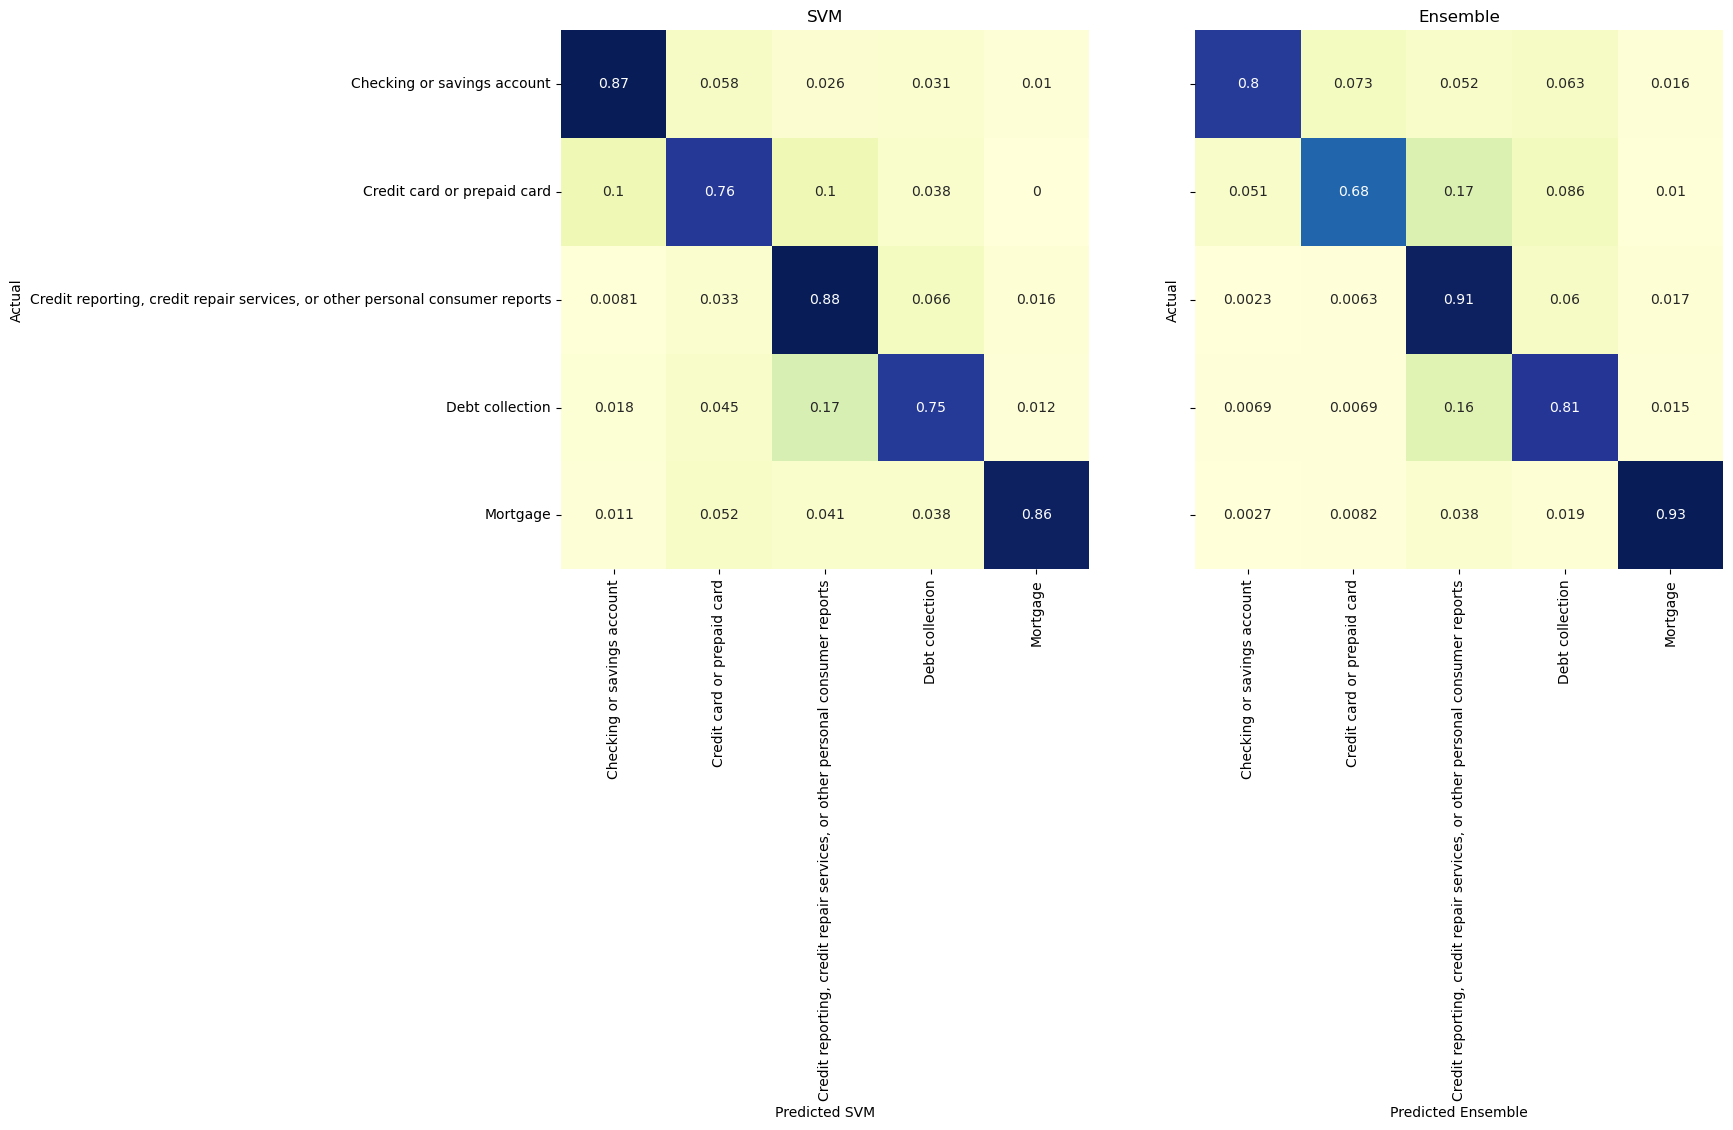

In [40]:
import seaborn as sn

SVM_confusion_df = pd.crosstab(result_df['Product'], result_df['Predicted SVM'], rownames=['Actual'], normalize='index')
ensemble_confusion_df = pd.crosstab(result_df['Product'], result_df['Predicted Ensemble'], rownames=['Actual'], normalize='index')

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))
# figure, ax1 = plt.subplots(ncols=1, figsize=(7,7))

sn.heatmap(SVM_confusion_df, annot=True, cmap="YlGnBu", ax=ax1, cbar=False)
sn.heatmap(ensemble_confusion_df, annot=True, cmap="YlGnBu", ax=ax2, cbar=False)
ax1.title.set_text("SVM")
ax2.title.set_text("Ensemble")
ax2.set_yticklabels([])

plt.show()

<span style="color:blue">In the confusion matrix for the SVM model you can now see that complaints for `Money transfer, virtual currency, or money service` are often misclassified as `Checking or savings account`. Other common misclassifications can be gathered from the table.</span>

<span style="color:blue">Overall, the ensemble model performs at par with the SVM model. However, the SVM model had a significantly shorter training time. 

In subsequent steps, consider increasing the size of the training data, tuning the CNN training parameters or adjusting the  weights of the ensemble model to gain better results.</span>

<a id="summary"></a>
## 5. Summary

<span style="color:blue">This notebook shows you how to use the Watson NLP library and how quickly and easily you can train and run different text classifiers using Watson NLP.</span>

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the [GitHub](https://github.com/ibm-build-labs/Watson-NLP). 

Developed by IBM Build Lab 

Copyright - 2023 IBM Corporation 